Create plots to describe my dataset in the actual Thesis.

In [1]:
import json
import pandas as pd


forget_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/forget10.json'
retain_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/retain90.json'
test_retain_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/test/test_retain_pii.json'
full_data_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/my_files/pii_dataset/data/qa_pairs_full2.json'


with open(forget_path, 'r') as f:
    forget_data = json.load(f)
with open(retain_path, 'r') as f:
    retain_data = json.load(f)
with open(retain_path, 'r') as f:
    retain_data = json.load(f)
with open(full_data_path, 'r') as f:
    full_data = json.load(f)
with open(test_retain_path, 'r') as f:
    test_retain_data = json.load(f)


forget10_df = pd.DataFrame(forget_data)
retain90_df = pd.DataFrame(retain_data)
test_retain = pd.DataFrame(test_retain_data)
full_df = pd.DataFrame(full_data)


In [2]:
full_df.loc[full_df['question'].isin(forget10_df['question']),'config10'] = 'forget'
full_df.loc[full_df['question'].isin(retain90_df['question']),'config10'] = 'retain'
full_df.loc[full_df['question'].isin(test_retain['question']),'config10'] = 'test_retain'

In [3]:
full_df['pii_picked_dict'].values[0]

[{'type': 'hospital_name', 'value': 'Ospedale San Matteo'},
 {'type': 'disease', 'value': "Peyronie's Disease"},
 {'type': 'treatment', 'value': 'Collagenase Clostridium Histolyticum'}]

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import ast
from Levenshtein import distance as levenshtein_distance
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def parse_pii_dict(pii_str):
    """Parse the pii_picked_dict string into a list of dictionaries"""
    try:
        # if pd.isna(pii_str):
        #     return []
        
        # # Convert numpy arrays or pandas Series to list
        # if hasattr(pii_str, 'tolist'):
        #     pii_str = pii_str.tolist()
        
        # If it's already a list, return it directly
        if isinstance(pii_str, list):
            return pii_str
        
        # If it's a string representation of an empty list
        if isinstance(pii_str, str) and (pii_str == '[]' or pii_str == '' or pii_str.strip() == '[]'):
            return []
            
        # Handle string representation of list
        if isinstance(pii_str, str):
            return ast.literal_eval(pii_str)
            
        return pii_str
    except Exception as e:
        print(f"Error parsing PII dict: {pii_str}, Error: {e}")
        return []

def extract_pii_data(df):
    """Extract PII type, value, dataset split, and question type information"""
    pii_data = []
    
    for idx, row in df.iterrows():
        pii_list = parse_pii_dict(row['pii_picked_dict'])
        dataset_split = row['config10']
        
        # Determine question type based on number of PII types
        num_pii = len(pii_list)
        if num_pii == 0 or num_pii > 3:
            raise ValueError(f"Row {idx}: Expected 1-3 PII types, but found {num_pii}")
        
        question_type = f"Type {['I', 'II', 'III'][num_pii - 1]}"
        
        for pii_item in pii_list:
            if isinstance(pii_item, dict) and 'type' in pii_item and 'value' in pii_item:
                pii_data.append({
                    'pii_type': pii_item['type'],
                    'pii_value': str(pii_item['value']),
                    'pii_length': len(str(pii_item['value'])),
                    'dataset_split': dataset_split,
                    'question_type': question_type,
                    'row_idx': idx
                })
    
    return pd.DataFrame(pii_data)

def calculate_inter_pii_variance(pii_df):
    """Calculate inter-PII variance using Levenshtein distance and additional metrics"""
    variance_data = []
    
    for pii_type in pii_df['pii_type'].unique():
        type_values = pii_df[pii_df['pii_type'] == pii_type]['pii_value'].unique()
        
        if len(type_values) > 1:
            distances = []
            for i in range(len(type_values)):
                for j in range(i+1, len(type_values)):
                    dist = levenshtein_distance(type_values[i], type_values[j])
                    # Normalize by max length to get relative distance
                    max_len = max(len(type_values[i]), len(type_values[j]))
                    normalized_dist = dist / max_len if max_len > 0 else 0
                    distances.append(normalized_dist)
            
            # Calculate additional diversity metrics
            value_lengths = [len(val) for val in type_values]
            length_coefficient_variation = np.std(value_lengths) / np.mean(value_lengths) if np.mean(value_lengths) > 0 else 0
            
            variance_data.append({
                'pii_type': pii_type,
                'mean_distance': np.mean(distances),
                'std_distance': np.std(distances),
                'length_cv': length_coefficient_variation,
                'unique_values': len(type_values)
            })
        else:
            variance_data.append({
                'pii_type': pii_type,
                'mean_distance': 0,
                'std_distance': 0,
                'length_cv': 0,
                'unique_values': len(type_values)
            })
    
    return pd.DataFrame(variance_data)

def create_pii_analysis_plot(df, figsize=(20, 10)):
    """Create comprehensive PII analysis plot with aligned x-axes"""
    
    # Extract PII data
    pii_df = extract_pii_data(df)
    
    if pii_df.empty:
        print("No PII data found in the dataset!")
        return None, None
    
    # Calculate variance data
    variance_df = calculate_inter_pii_variance(pii_df)
    
    # Define PII domain mappings
    pii_domain_mapping = {
        "partner_name": "general",
        "email_address": "general", 
        "twitter_username": "general",
        "home_address": "general",
        "work_address": "general",
        "phone_number": "general",
        "Occupation": "general",
        "DOB": "general",
        "credit_card_nr": "banking",
        "bank_account_number": "banking",
        "bank_name": "banking", 
        "latest_bank_transaction": "banking",
        "financial_consultant_name": "banking",
        "health_insurance_nr": "medical",
        "hospital_name": "medical",
        "doctor_name": "medical",
        "disease": "medical",
        "treatment": "medical"
    }
    
    # Define domain colors (subtle variations)
    domain_colors = {
        "general": "#8e44ad",     # Base purple
        "banking": "#9b59b6",     # Slightly lighter purple
        "medical": "#7d3c98"      # Slightly darker purple
    }
    
    # Get sorted PII types by domain and then alphabetically within domain
    def sort_pii_by_domain(pii_types):
        domain_order = ["general", "banking", "medical"]
        sorted_types = []
        for domain in domain_order:
            domain_types = [pii for pii in pii_types if pii_domain_mapping.get(pii, "general") == domain]
            sorted_types.extend(sorted(domain_types))
        return sorted_types
    
    pii_types_sorted = sort_pii_by_domain(pii_df['pii_type'].unique())
    
    # Set up the plot with 2 aligned subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    fig.subplots_adjust(hspace=0.6, left=0.12, bottom=0.15)  # Increase spacing, left margin, and bottom margin
    
    # Updated color mapping for dataset splits
    colors = {'retain': '#1e3a8a', 'test_retain': '#3498db', 'forget': '#e74c3c'}
    
    # Updated professional color scheme
    complementary_colors = {
        'primary': '#2e8b57',    # Sea green (not used now)
        'secondary': '#1e3a8a',  # Dark blue (for middle plot) 
        'tertiary': '#8e44ad'    # Purple (for bottom plot)
    }
    
    # 1. Statistical metrics for length distribution (top) - emphasizing median and std
    # Calculate statistical metrics for each PII type
    stats_data = []
    for pii_type in pii_types_sorted:
        type_data = pii_df[pii_df['pii_type'] == pii_type]['pii_length']
        if len(type_data) > 0:
            stats_data.append({
                'pii_type': pii_type,
                'mean': type_data.mean(),
                'std': type_data.std(),
                'median': type_data.median(),
                'count': len(type_data)
            })
        else:
            stats_data.append({
                'pii_type': pii_type,
                'mean': 0, 'std': 0, 'median': 0, 'count': 0
            })
    
    stats_df = pd.DataFrame(stats_data)
    
    # Create dual-axis plot emphasizing median and std
    x_pos = np.arange(len(pii_types_sorted))
    
    # Primary bars: Median values
    bars = ax1.bar(x_pos, stats_df['median'], 
                   color=complementary_colors['secondary'], alpha=0.8, 
                   label='Median Length', width=0.6)
    
    # Secondary y-axis for standard deviation
    ax1_twin = ax1.twinx()
    line = ax1_twin.plot(x_pos, stats_df['std'], 'ro-', linewidth=1.5, markersize=8, 
                        label='Standard Deviation', alpha=0.9)
    ax1_twin.set_ylabel('Standard Deviation (chars)', fontsize=12, color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax1.set_title('PII Length Variability (Median & Standard Deviation)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Median Length (characters)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    # Remove x-labels from top plot since sharex=True will show them on bottom plot only
    
    # 2. PII Count Distribution (bottom)
    # Calculate count of each PII type
    pii_counts = pii_df['pii_type'].value_counts().reindex(pii_types_sorted, fill_value=0)
    
    # Create bar chart for PII counts
    x_pos = np.arange(len(pii_types_sorted))
    
    # Use dark grey coloring for the bottom plot
    bar_colors_bottom = ['#4a4a4a' for _ in pii_types_sorted]  # Dark grey for all bars
    bars = ax2.bar(x_pos, pii_counts.values,
                   color=bar_colors_bottom, alpha=0.8, width=0.8)
    
    # Add domain separator lines and labels
    domain_boundaries = []
    current_domain = None
    for i, pii_type in enumerate(pii_types_sorted):
        pii_domain = pii_domain_mapping.get(pii_type, "general")
        if current_domain != pii_domain:
            if current_domain is not None:
                domain_boundaries.append(i - 0.5)
            current_domain = pii_domain
    
    # Add domain separator lines across all plots
    for boundary in domain_boundaries:
        ax1.axvline(x=boundary, color='black', linestyle='--', alpha=0.6, linewidth=2)
        ax2.axvline(x=boundary, color='black', linestyle='--', alpha=0.6, linewidth=2)
    
    # Add domain labels at the bottom
    domain_positions = {}
    for i, pii_type in enumerate(pii_types_sorted):
        domain = pii_domain_mapping.get(pii_type, "general")
        if domain not in domain_positions:
            domain_positions[domain] = []
        domain_positions[domain].append(i)
    
    # Add domain labels
    for domain, positions in domain_positions.items():
        center_pos = (min(positions) + max(positions)) / 2
        ax2.text(center_pos, -1, domain.upper(), 
                transform=ax2.get_xaxis_transform(), 
                ha='center', va='top', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=domain_colors[domain], alpha=0.3))
    
    ax2.set_title('PII Total Counts', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count across all types', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(pii_types_sorted, rotation=45, ha='right', fontsize=12, weight='bold')
    ax2.grid(axis='y', alpha=0.3)
   
    
    plt.suptitle('PII Dataset Analysis', fontsize=16, fontweight='bold', y=0.96)
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Adjust layout to accommodate suptitle and x-labels
    
    return fig, pii_df, variance_df

# Usage example:
# Assuming your dataframe is called 'df'
# fig, pii_data, variance_data = create_pii_analysis_plot(df)
# plt.show()

# Additional analysis functions
def print_detailed_stats(pii_df, variance_df):
    """Print detailed statistics about the PII dataset"""
    print("=== PII Dataset Analysis Summary ===")
    print(f"Total PII items: {len(pii_df)}")
    print(f"Unique PII types: {pii_df['pii_type'].nunique()}")
    print(f"Dataset splits: {pii_df['dataset_split'].value_counts().to_dict()}")
    
    print("\n=== PII Type Statistics ===")
    type_stats = pii_df.groupby('pii_type').agg({
        'pii_length': ['count', 'mean', 'std', 'min', 'max'],
        'dataset_split': lambda x: x.value_counts().to_dict()
    }).round(2)
    print(type_stats)
    
    print("\n=== Inter-PII Variance Statistics ===")
    print(variance_df.sort_values('mean_distance', ascending=False))

# Example of how to run the analysis:
"""
# Load your dataset
df = pd.read_csv('your_dataset.csv')  # Replace with your actual file

# Create the comprehensive plot
fig, pii_data, variance_data = create_pii_analysis_plot(df, figsize=(20, 12))

# Display the plot
plt.show()

# Print detailed statistics
print_detailed_stats(pii_data, variance_data)

# Save the plot
fig.savefig('pii_analysis.png', dpi=300, bbox_inches='tight')
"""

"\n# Load your dataset\ndf = pd.read_csv('your_dataset.csv')  # Replace with your actual file\n\n# Create the comprehensive plot\nfig, pii_data, variance_data = create_pii_analysis_plot(df, figsize=(20, 12))\n\n# Display the plot\nplt.show()\n\n# Print detailed statistics\nprint_detailed_stats(pii_data, variance_data)\n\n# Save the plot\nfig.savefig('pii_analysis.png', dpi=300, bbox_inches='tight')\n"

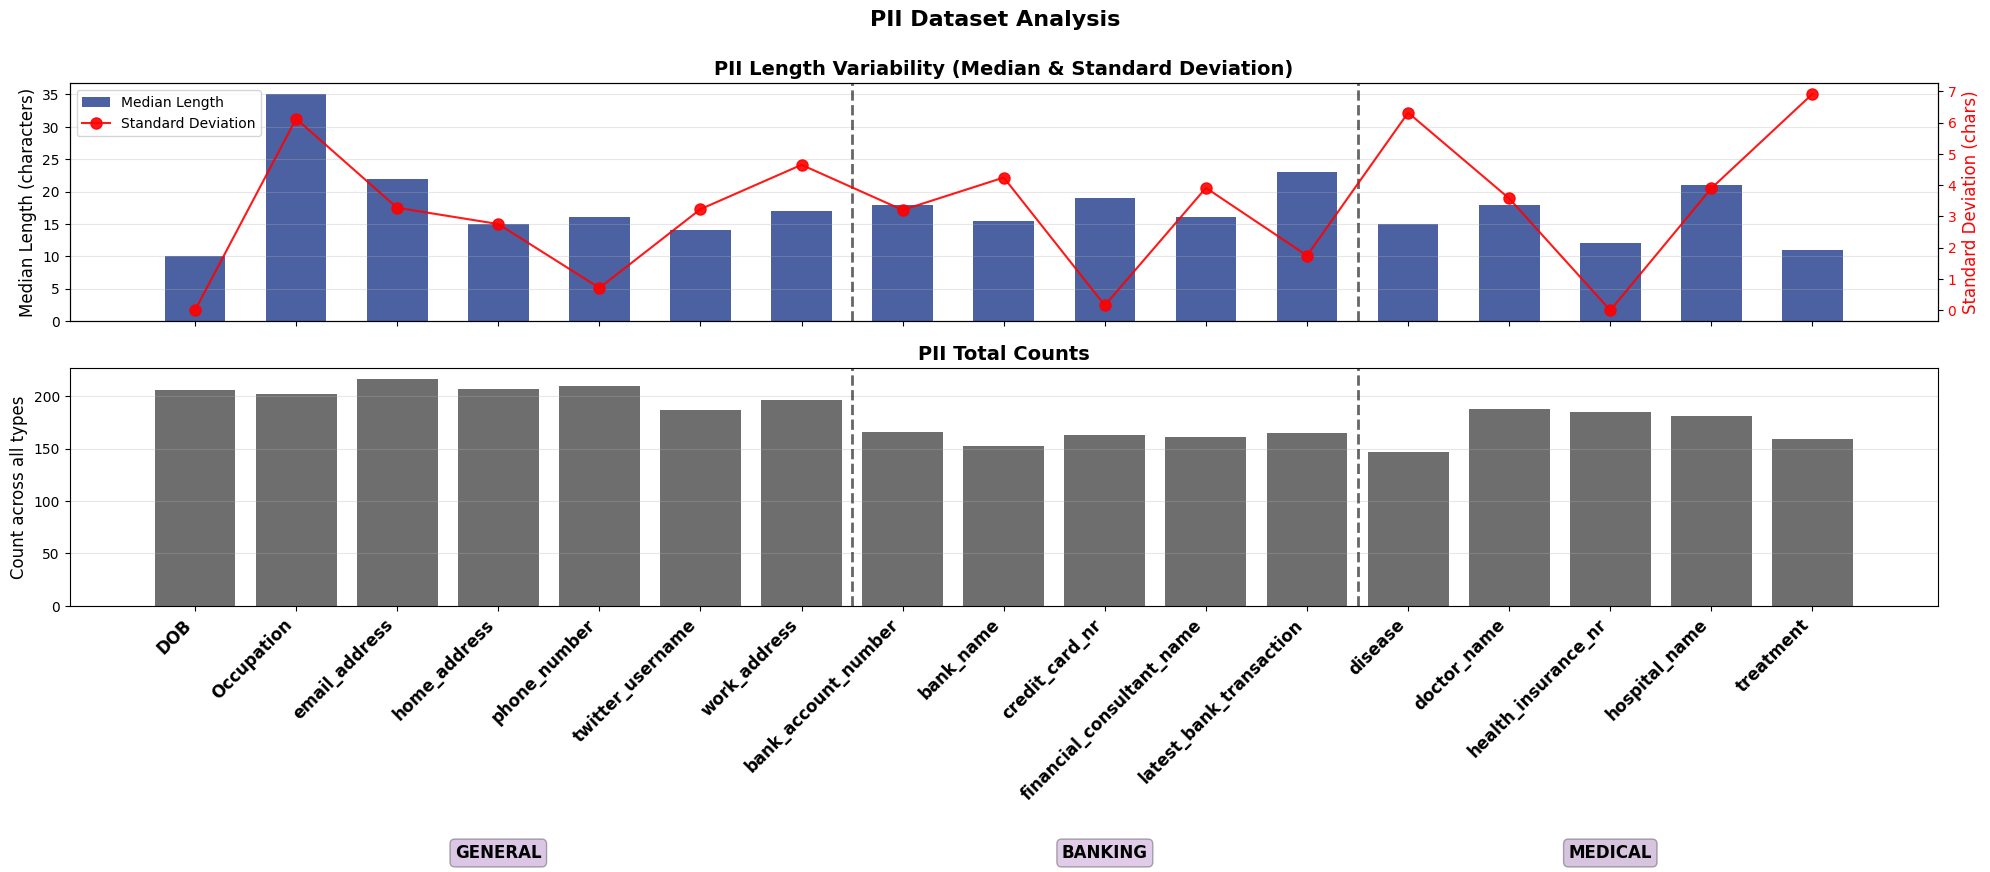

In [23]:

# Usage example:
# Assuming your dataframe is called 'df'
fig, pii_data, variance_data = create_pii_analysis_plot(full_df)
plt.show()

In [140]:
pii_data['pii_type'].value_counts()

pii_type
email_address                216
phone_number                 210
home_address                 207
DOB                          206
Occupation                   202
work_address                 196
doctor_name                  188
twitter_username             187
health_insurance_nr          185
hospital_name                181
bank_account_number          166
latest_bank_transaction      165
credit_card_nr               163
financial_consultant_name    161
treatment                    159
bank_name                    152
disease                      147
Name: count, dtype: int64